In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time 
import h5py
import scipy.linalg as linalg
import ActivityPatterns as ap
import ThermalImagingAnalysis as tai
import scipy.io
import sklearn.metrics
from sklearn import mixture
import opengm
from scipy.linalg import norm
from numpy.linalg import lstsq

In [2]:
# Data and parametric component
pPenalty = "Penalty_Gaussian_1024fr_2.5Hz_TruncatedWaveletBasis.mat"
pioData = h5py.File("626510_sep.mat","r")
S = np.array(pioData["S1024"])
T = np.array(pioData["T1024"])
S2 = S[0:1024,]
T2 = T[0:1024,]
noTimepoints, noPixels = S2.shape
f_P = h5py.File(pPenalty, "r")
P = f_P["BPdir2"].value   # learned penalty matrix
print('[INFO] P is being transposed\n')
P = P.transpose() # P appears to be stored as transposed version of itself
B = f_P["B"].value # basis matrix

[INFO] P is being transposed



ThermalImagingAnalysis.py:84: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta_mrf  = lstsq(P,pbeta_mrf)


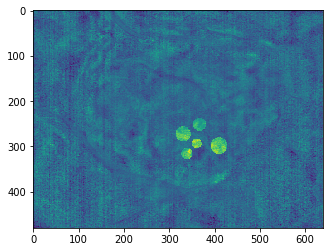

In [3]:
#compute gaussian activity pattern
X = ap.computeGaussianActivityPattern(np.squeeze(T2)).transpose();
lambda_pairwise = 1
num_clusters = 10
#semiparametric regression
Z = tai.semiparamRegression(S2, X, B, P, num_clusters,noPixels,lambda_pairwise)
plt.imshow(Z.reshape(640,480).transpose())
plt.show()

In [5]:
groundtruthImg = np.array(pioData["groundtruthImg"].value)
groundtruth_foreground = np.where(groundtruthImg > 0)[0]
groundtruth_background = np.where(groundtruthImg == 0)[0]
true_positive =  len(np.where(abs(Z[groundtruth_foreground,]) >= 5.2)[0])                                  
false_positive = len(np.where(abs(Z[groundtruth_foreground,]) < 5.2)[0])
true_negative = len(np.where(abs(Z[groundtruth_background,]) < 5.2)[0])
false_negative = len(np.where(abs(Z[groundtruth_background,]) >= 5.2)[0])
true_positive_rate = true_positive / np.float32(len(groundtruth_foreground))
false_positive_rate = false_positive / np.float32(len(groundtruth_background))
accuracy  = (true_positive + true_negative) / np.float32(len(groundtruth_background) + len(groundtruth_foreground))

In [6]:
true_positive

2946

In [7]:
false_positive

547

In [8]:
true_negative

303518

In [9]:
false_negative

189

In [10]:
true_positive_rate

0.8434010878900658

In [11]:
false_positive_rate

0.0018010780126898622

In [12]:
accuracy

0.9976041666666666

In [13]:
#F1 score metrics for better evaluation
Z_true = groundtruthImg.flatten()
for i in range(len(Z_true)):
    if Z_true[i] != 0:
       Z_true[i] = 1
    else:
       Z_true[i] = 0

In [14]:
Z_pred = np.zeros(len(Z_true))
for i in range(len(Z_pred)):
    if Z[i] >= 5.2:
       Z_pred[i] = 1
    else:
       Z_pred[i] = 0

In [15]:
F1 = sklearn.metrics.f1_score(Z_true, Z_pred, average='binary')

In [16]:
F1

0.8911070780399275

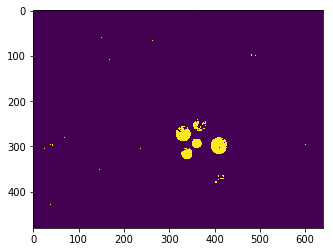

In [17]:
plt.imshow(Z_pred.reshape(640,480).transpose())